# Scratch Pad & Notes

* This is a scratch pad to understand what is going on in the data



## What do we know so far
* Phone calls are a heavy time usage vector
* Some high traffic from web
* Lots of phone load is expensive and time consuming
## Key notes

* 72515 rows in omni channel 
* 32289 unique work items in omni channel
* 2+ on average routes through the channel, must be follow ups
* 19650 `work_item_id` and `cases id`, so massively massively lower 


* phone has 75,810 rows, 43,445 sessions and calls --> Calls are being duplicated 


* Whatsapp 17956 idx and 11685 case idx, so again some are in there multiple times, we also have bots, but we don't know if the bot can reply


* Phone so 57% of these calls are inbound and take on average over 12 minutes -- let's actually plot these out to confirm
* A massive volume of Web-originated cases are being logged for “Profile Text”, likely:

* Related to profile setup, display issues, or edits.

* Maybe during sign-up, or profile management from a self-serve portal.

* These may not be agent-handled in real time (hence missing from Omni-channel), which explains:

The lack of routing queue info Possibly inconsistent or missing status updates in the dataset



### Problem:
* “13,700+ Web-originated cases about 'Profile Text' account for a huge share of incoming issues. However, most are not routed through Salesforce Omni-Channel, suggesting they are either auto-logged or handled asynchronously. This makes them a prime candidate for automation.”
* These cases likely clog up the support backlog. Since they don't go through Omni-channel, there may be no tracking, SLAs, or triage.

* Almost 7k calls about Invoices or Lead Generation
 * I can't imagine anyone is calling into to say thanks so much my leads are amazing

### Solution Opportunity:

* Build a form-integrated AI assistant (e.g. GPT-powered UI help) to:

* Pre-emptively answer questions about profile text formatting

* Auto-correct or review issues before the case is even submitted

* Or auto-classify and summarize these Web cases to allow triage without a human.


***
* Interestingly profile text is not there https://support.checkatrade.com/s/article/How-do-I-update-my-company-contact-details


## Modules

In [39]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
from pathlib import Path
import sqlite3
Path.cwd().parent

PosixPath('/Users/asiflaldin/Documents/Projects/check-a-trade')

## Connect to `check_marts`

In [ ]:

root = Path.cwd().parent 
db_path = root / "db" / "check_marts.db"

conn = sqlite3.connect(db_path)
cursor = conn.cursor()

tables = cursor.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
print("Tables:", tables)


Tables: [('phone',), ('cases',), ('salesforce_omni_channel',), ('whatsapp',)]


In [74]:
pd.read_sql_query(
    """
SELECT
    c.issue_type,
    COUNT(w.case_id) AS wa_sessions,
    AVG(w.agent_message_count) AS avg_agent_messages,
    SUM(CASE WHEN w.agent_type = 'Agent' THEN 1 ELSE 0 END) * 1.0 / COUNT(*) AS agent_handled_rate
FROM
    whatsapp w
LEFT JOIN
    cases c
    ON w.case_id = c.id
GROUP BY 1
ORDER BY
    wa_sessions DESC,
    avg_agent_messages DESC
    """,con=conn
)

,issue_type,wa_sessions,avg_agent_messages,agent_handled_rate
0,None,2727,0.564125,0.289175
1,WhatsApp No Info,1209,1.296940,0.959471
2,Lead Volume - Not enough leads,853,2.434936,0.981243
3,Not Listed on Account,505,1.257426,0.992079
4,Postcode,501,2.013972,0.994012
...,...,...,...,...
67,Wrong number,2,3.000000,1.000000
68,Customer refund query,1,10.000000,1.000000
69,Customer chargeback request/support,1,0.000000,1.000000
70,Police,1,0.000000,1.000000


In [42]:
pd.read_sql_query(
    """  
SELECT
    c.issue_type,
    COUNT(*) AS session_count
FROM
    whatsapp w
JOIN
    cases c ON w.case_id = c.id
GROUP BY 1
ORDER BY 2 DESC


""",con=conn
)

,issue_type,session_count
0,WhatsApp No Info,1209
1,None,1026
2,Lead Volume - Not enough leads,853
3,Not Listed on Account,505
4,Postcode,501
...,...,...
67,Customer payment error,2
68,Trade chargeback support,1
69,Police,1
70,Customer refund query,1


In [43]:
pd.read_sql_query(
    """  
SELECT
    c.origin,
    COUNT(*) AS session_count
FROM
    whatsapp w
JOIN
    cases c ON w.case_id = c.id
GROUP BY 1
ORDER BY 2 DESC
""",con=conn
)

,origin,session_count
0,WhatsApp,9862
1,Phone,109
2,Email,8
3,Community,3
4,Web,2


In [44]:
pd.read_sql_query(
    """  
SELECT
    team_taking_callback,
    COUNT(*) AS session_count,
    COUNT(DISTINCT id) AS niqes
FROM
    cases
GROUP BY 1

""",con=conn
)

,team_taking_callback,session_count,niqes
0,None,56936,56936
1,Credit Control,47,47
2,Cross Sales,114,114
3,Customer Service,143,143
4,EMV,7,7
5,Guarantee,1,1
6,MA,6,6
7,Member Promise,1,1
8,Retention,164,164
9,Reviews,12,12


In [ ]:
pd.read_sql_query(
    """  
SELECT
    c.origin,
    c.issue_type,
    COUNT(*) AS cases
FROM 
    salesforce_omni_channel o
INNER JOIN  cases c 
    ON o.work_item_id = c.id
group by 1,2
order by 3 desc
""",con=conn

)

,origin,issue_type,records
0,Phone,Lead Volume - Not enough leads,1381
1,Email,Checkatrade Email Spam Received,926
2,Email,Not Listed on Account,925
3,Email,Lead Volume - Not enough leads,537
4,Community,Lead Volume - Not enough leads,497
...,...,...,...
255,WhatsApp,Pre RVM - Not Live Yet,1
256,WhatsApp,Ranking,1
257,WhatsApp,Reporting Spam,1
258,WhatsApp,Secure Contact,1


In [ ]:
pd.read_sql_query(
    """  
SELECT
    c.issue_type,
    COUNT(*) AS cases
FROM 
    salesforce_omni_channel o
INNER JOIN  cases c 
    ON o.work_item_id = c.id
group by 1
order by 2 desc
""",con=conn

)

,issue_type,COUNT(*)
0,Lead Volume - Not enough leads,2443
1,Not Listed on Account,1274
2,Checkatrade Email Spam Received,972
3,Invoice amount query,921
4,Ceased Trading,763
...,...,...
64,Trade refund request,5
65,Trade payment error,2
66,Pro rata query,2
67,Debt at Sign Up,2


In [75]:
pd.read_sql_query(

    """  
SELECT
    campaign, 
    call_type, 
    COUNT(*) AS rows,
    AVG(handle_time) AS avg_handle_time_m
FROM phone
GROUP BY 1,2
""",con=conn

)

,campaign,call_type,rows,avg_handle_time_m
0,MAT - Membership Advice,3rd party transfer,32273,1.244803
1,MAT - Membership Advice,Inbound,43435,12.417532
2,MAT - Membership Advice,Queue Callback,102,12.066500


In [48]:
pd.read_sql_query(
    """  
SELECT c.issue_type,
    AVG(p.handle_time),
    COUNT(*) AS cases
FROM 
    phone AS p
INNER JOIN
    cases AS c
    ON p.session_id = c.session_id
GROUP BY 1
ORDER BY 3 DESC,2 DESC
""",con=conn)

,issue_type,AVG(p.handle_time),cases
0,Lead Volume - Not enough leads,13.440826,3523
1,Invoice amount query,11.671337,3429
2,None,9.279766,1985
3,Owes Debt,6.932702,1250
4,Directory,13.306286,1042
...,...,...,...
65,Name,14.466667,3
66,Customer refund query,13.341667,3
67,Customer chargeback request/support,24.750000,2
68,Pro rata query,13.150000,2


## Phone calls 
* Leads and Invoices
Getting close-ish to a pareto distribution

* Interesting article about lead generation 
https://www.checkatrade.com/blog/trade/grow-business/lead-generation-strategies/

In [49]:
pd.read_sql_query(
    """  
SELECT c.issue_type,
    AVG(p.handle_time),
    COUNT(*) AS cases
FROM 
    phone AS p
INNER JOIN
    cases AS c
    ON p.session_id = c.session_id
GROUP BY 1
ORDER BY 3 DESC,2 DESC
""",con=conn)


,issue_type,AVG(p.handle_time),cases
0,Lead Volume - Not enough leads,13.440826,3523
1,Invoice amount query,11.671337,3429
2,None,9.279766,1985
3,Owes Debt,6.932702,1250
4,Directory,13.306286,1042
...,...,...,...
65,Name,14.466667,3
66,Customer refund query,13.341667,3
67,Customer chargeback request/support,24.750000,2
68,Pro rata query,13.150000,2


### Confirm Difference Between Leads & Invoices

Group A mean: 11.671 | Group B mean: 13.441
U-statistic: 1707602.000
Cliff's Delta (effect size): -0.101
✅ Statistically significant difference between groups.
Descriptive Statistics:
Group A:
  Min      : 0.017
  Max      : 64.783
  n        : 1977.000
  Mean     : 11.671
  Median   : 10.183
  Std Dev  : 8.729
  Skew     : 1.530
  Kurtosis : 4.312
------------------------------------------------------------
Group B:
  Min      : 0.033
  Max      : 95.067
  n        : 1922.000
  Mean     : 13.441
  Median   : 11.517
  Std Dev  : 10.107
  Skew     : 1.846
  Kurtosis : 7.094
------------------------------------------------------------


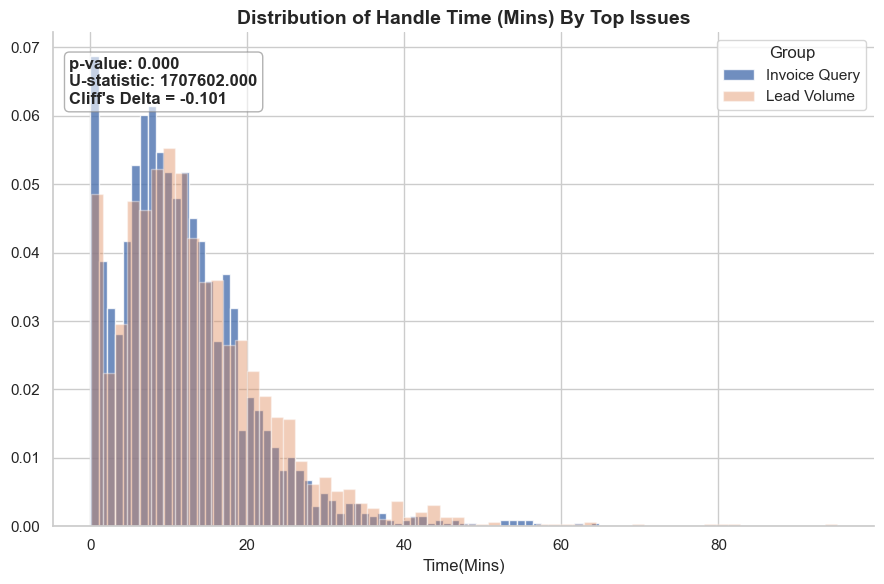

In [50]:
phone_top = pd.read_sql_query(
    """  
SELECT 
    c.issue_type, 
    p.handle_time
FROM 
    phone AS p
INNER JOIN
    cases AS c
    ON p.session_id = c.session_id
WHERE c.issue_type IN ("Lead Volume - Not enough leads","Invoice amount query")
""",con=conn)



phone_top.dropna(inplace=True)

import sys
import os
sys.path.append(os.path.abspath(".."))  # go up one level from notebooks/

from utils.inferential_statistics import IndependentGroupsAnalysis


analyser = IndependentGroupsAnalysis()

group_a = phone_top[phone_top['issue_type']== 'Invoice amount query']['handle_time']
group_b = phone_top[phone_top['issue_type']== 'Lead Volume - Not enough leads']['handle_time']


analyser.load_data(group_a=group_a,group_b=group_b)

analyser.test_non_parametric_groups()
analyser.summarise()
analyser.describe()
analyser.plot_distributions(label_a="Invoice Query",
                            label_b="Lead Volume",
                            title='Distribution of Handle Time (Mins) By Top Issues',
                            xlabel="Time(Mins)")


In [51]:

pd.read_sql_query(
    """  
SELECT 
    w.*,c.*,s.*
FROM 
    whatsapp AS w
INNER JOIN 
    cases  AS c
    ON w.case_id = c.id
INNER JOIN 
    salesforce_omni_channel AS s
    ON s.work_item_id = c.id

WHERE 
    w.agent_Type != 'Bot'
""",con=conn

)

,created_date,id,accept_time,agent_type,agent_message_count,case_id,channel_name,status,created_date,id,...,callback_reason,team_taking_callback,created_date,work_item_id,speed_to_answer,handle_time,status,queue_name,close_date_time,assigned_date_time
0,2024-11-04 09:23:35+00:00,0MwJ7000000x0efKAA,None,Agent,7,500J7000005fnDPIAY,Inbound Messaging,Ended,2024-11-04 09:26:15+00:00,500J7000005fnDPIAY,...,None,None,2024-11-13 15:04:27+00:00,500J7000005fnDPIAY,NaN,NaN,Unavailable,Membership Advice Case Queue,None,2024-11-13 15:04:27+00:00
1,2024-11-04 09:23:35+00:00,0MwJ7000000x0efKAA,None,Agent,7,500J7000005fnDPIAY,Inbound Messaging,Ended,2024-11-04 09:26:15+00:00,500J7000005fnDPIAY,...,None,None,2024-11-13 15:07:13+00:00,500J7000005fnDPIAY,628229.0,5.716667e-09,Closed,Membership Advice Case Queue,2024-11-13 15:13:46+00:00,2024-11-13 15:07:13+00:00
2,2024-11-04 10:36:06+00:00,0MwJ7000000x0jfKAA,None,Agent,6,500J7000005fnblIAA,Inbound Messaging,Ended,2024-11-04 10:37:29+00:00,500J7000005fnblIAA,...,None,None,2024-11-13 16:28:36+00:00,500J7000005fnblIAA,625738.0,1.466667e-09,Closed,Membership Advice Case Queue,2024-11-13 16:31:25+00:00,2024-11-13 16:28:36+00:00
3,2024-11-04 10:36:06+00:00,0MwJ7000000x0jfKAA,None,Agent,6,500J7000005fnblIAA,Inbound Messaging,Ended,2024-11-04 10:37:29+00:00,500J7000005fnblIAA,...,None,None,2024-11-20 16:24:36+00:00,500J7000005fnblIAA,454403.0,1.100000e-09,Closed,Membership Advice Case Queue,2024-11-20 16:34:11+00:00,2024-11-20 16:24:36+00:00
4,2024-11-04 15:21:23+00:00,0MwJ7000000x10bKAA,None,Agent,1,500J7000005fpBGIAY,Inbound Messaging,Ended,2024-11-04 15:23:00+00:00,500J7000005fpBGIAY,...,None,None,2024-11-13 08:07:10+00:00,500J7000005fpBGIAY,682271.0,1.350000e-09,Closed,Membership Advice Case Queue,2024-11-13 08:10:58+00:00,2024-11-13 08:07:10+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,2025-01-22 12:13:56+00:00,0MwP200000482VNKAY,None,Agent,1,500P200000Xd925IAB,Inbound Messaging,Ended,2025-01-22 12:15:09+00:00,500P200000Xd925IAB,...,None,None,2025-01-26 15:14:02+00:00,500P200000Xd925IAB,96186.0,1.638333e-08,Closed,Membership Advice Case Queue,2025-01-26 15:30:54+00:00,2025-01-26 15:14:02+00:00
366,2025-01-23 02:44:09+00:00,0MwP200000494BlKAI,None,Agent,4,500P200000XgxVLIAZ,Inbound Messaging,Ended,2025-01-23 02:40:11+00:00,500P200000XgxVLIAZ,...,None,None,2025-01-23 19:52:00+00:00,500P200000XgxVLIAZ,NaN,NaN,Unavailable,Membership Advice Case Queue,None,2025-01-23 19:52:00+00:00
367,2025-01-23 02:44:09+00:00,0MwP200000494BlKAI,None,Agent,4,500P200000XgxVLIAZ,Inbound Messaging,Ended,2025-01-23 02:40:11+00:00,500P200000XgxVLIAZ,...,None,None,2025-01-24 08:00:42+00:00,500P200000XgxVLIAZ,85162.0,2.060000e-08,Closed,Membership Advice Case Queue,2025-01-24 08:21:24+00:00,2025-01-24 08:00:42+00:00
368,2025-01-23 12:58:40+00:00,0MwP20000049jjZKAQ,None,Agent,3,500P200000XjJoIIAV,Inbound Messaging,Ended,2025-01-23 13:00:05+00:00,500P200000XjJoIIAV,...,None,None,2025-01-24 15:26:07+00:00,500P200000XjJoIIAV,21561.0,3.116667e-09,Closed,Membership Advice Case Queue,2025-01-24 15:29:16+00:00,2025-01-24 15:26:07+00:00


 So What?
The Messaging Queue has more re-routing or handoffs per item.

Suggests more complexity or back-and-forth in messaging cases.

May benefit from automation, better triage, or clearer ownership.

Membership Advice cases are more straightforward, with fewer events per case.

May be better structured or more predictable.

In [52]:
pd.read_sql_query(
    """  
SELECT 
    queue_name,
    COUNT(DISTINCT work_item_id),
    COUNT(*)
FROM
    salesforce_omni_channel
GROUP BY 1
ORDER BY 2 DESC
""",con=conn
)

,queue_name,COUNT(DISTINCT work_item_id),COUNT(*)
0,Messaging Queue,17735,48144
1,Membership Advice Case Queue,14554,24371


In [53]:
pd.read_sql_query(
    """  
WITH routing_counts AS (
    SELECT 
        work_item_id,
        COUNT(*) AS routing_count
    FROM 
        salesforce_omni_channel
    GROUP BY 
        work_item_id
),

queue_summary AS (
    SELECT 
        queue_name,
        work_item_id
    FROM 
        salesforce_omni_channel
    GROUP BY 
        queue_name, work_item_id
)

SELECT 
    q.queue_name,
    COUNT(q.work_item_id) AS unique_work_items,
    SUM(r.routing_count) AS total_routing_events,
    ROUND(AVG(r.routing_count), 2) AS avg_routing_events_per_item,
    ROUND(100.0 * SUM(CASE WHEN r.routing_count > 1 THEN 1 ELSE 0 END) / COUNT(q.work_item_id), 1) AS pct_multi_touch_items

FROM 
    queue_summary q
JOIN 
    routing_counts r ON q.work_item_id = r.work_item_id
GROUP BY 
    q.queue_name
ORDER BY 
    unique_work_items DESC;
""",con=conn
)

,queue_name,unique_work_items,total_routing_events,avg_routing_events_per_item,pct_multi_touch_items
0,Messaging Queue,17735,48144,2.71,65.6
1,Membership Advice Case Queue,14554,24371,1.67,34.7


In [54]:
pd.read_sql_query(
    """  
WITH routing_counts AS (
    SELECT 
        work_item_id,
        COUNT(*) AS routing_count
    FROM 
        salesforce_omni_channel
    GROUP BY 
        work_item_id
),

queue_summary AS (
    SELECT 
        queue_name,
        work_item_id
    FROM 
        salesforce_omni_channel
    GROUP BY 
        queue_name, work_item_id
),

linked_cases AS (
    SELECT 
        w.id AS whatsapp_id,
        w.case_id,
        c.id AS case_id,
        q.queue_name,
        r.routing_count
    FROM 
        whatsapp w
    JOIN 
        cases c ON w.case_id = c.id
    JOIN 
        queue_summary q ON c.id = q.work_item_id
    JOIN 
        routing_counts r ON q.work_item_id = r.work_item_id
)

SELECT 
    queue_name,
    COUNT(DISTINCT case_id) AS whatsapp_cases,
    ROUND(AVG(routing_count), 2) AS avg_routing_events_per_case
FROM 
    linked_cases
GROUP BY 
    queue_name
ORDER BY 
    whatsapp_cases DESC;

""",con=conn
)

,queue_name,whatsapp_cases,avg_routing_events_per_case
0,Membership Advice Case Queue,182,1.92


In [55]:

pd.read_sql_query(
    """  
SELECT
    issue_type, 
    COUNT(*) AS nums
FROM
    cases
GROUP BY 1
ORDER BY 2 DESC
""",con=conn
)

,issue_type,nums
0,Profile Text,13983
1,Accreditation,5056
2,Lead Volume - Not enough leads,4262
3,Invoice amount query,2728
4,PLI,2656
...,...,...
68,Customer refund query,5
69,Trade refund request,3
70,Customer chargeback request/support,2
71,Trade chargeback support,1


In [56]:

pd.read_sql_query(
    """  
SELECT 
    issue_type,
    COUNT(*) AS case_count
FROM 
    salesforce_omni_channel o
INNER JOIN 
    cases c ON o.work_item_id = c.id
WHERE 
    c.issue_type = 'Profile Text'
GROUP BY 1
ORDER BY 2 DESC
""",con=conn
)

,issue_type,case_count
0,Profile Text,548


In [57]:

pd.read_sql_query(
    """  
SELECT 
    origin,
    COUNT(*) AS case_count
FROM 
    cases 
WHERE 
    issue_type = 'Profile Text'
GROUP BY 
1
""",con=conn
)

,origin,case_count
0,None,1
1,Community,31
2,Email,37
3,Phone,130
4,Web,13739
5,WhatsApp,45


In [58]:

pd.read_sql_query(
    """  
SELECT *
FROM 
    cases AS c
INNER JOIN salesforce_omni_channel AS s 
    ON c.id = s.work_item_id
WHERE 
    c.issue_type = 'Profile Text'

GROUP BY 
1
""",con=conn
)

,created_date,id,case_number,origin,status,issue_type,session_id,trader_id,callback_reason,team_taking_callback,created_date,work_item_id,speed_to_answer,handle_time,status,queue_name,close_date_time,assigned_date_time
0,2024-11-05 17:54:36+00:00,500J7000005ftuUIAQ,523682,Community,Closed,Profile Text,None,1123103.0,None,None,2024-11-13 13:29:15+00:00,500J7000005ftuUIAQ,675286.0,2.333333e-09,Closed,Membership Advice Case Queue,2024-11-13 13:31:42+00:00,2024-11-13 13:29:15+00:00
1,2024-11-06 13:15:37+00:00,500J7000005fx45IAA,524884,Phone,Closed,Profile Text,None,258489.0,None,None,2024-11-13 17:53:08+00:00,500J7000005fx45IAA,621702.0,9.716667e-09,Closed,Membership Advice Case Queue,2024-11-13 18:07:56+00:00,2024-11-13 17:53:08+00:00
2,2024-11-11 09:35:51+00:00,500J7000005gAZYIA2,530191,Email,Closed,Profile Text,None,383243.0,None,None,2024-11-18 13:31:21+00:00,500J7000005gAZYIA2,611153.0,4.166667e-10,Closed,Membership Advice Case Queue,2024-11-18 13:31:56+00:00,2024-11-18 13:31:21+00:00
3,2024-11-12 11:48:17+00:00,500J7000005gG2RIAU,532894,Web,Approved,Profile Text,None,1120262.0,None,None,2024-11-22 15:13:37+00:00,500J7000005gG2RIAU,255318.0,6.166667e-10,Closed,Membership Advice Case Queue,2024-11-22 15:30:35+00:00,2024-11-22 15:13:37+00:00
4,2024-11-12 15:02:29+00:00,500J7000005gHHpIAM,533566,Phone,Closed,Profile Text,None,1123321.0,None,None,2024-12-16 12:04:03+00:00,500J7000005gHHpIAM,258154.0,6.866667e-09,Closed,Membership Advice Case Queue,2024-12-16 12:19:02+00:00,2024-12-16 12:04:03+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,2025-01-25 14:41:46+00:00,500P200000XsXDoIAN,655245,Web,Approved,Profile Text,None,1099266.0,None,None,2025-01-26 15:54:43+00:00,500P200000XsXDoIAN,90787.0,1.766667e-09,Closed,Membership Advice Case Queue,2025-01-26 15:56:39+00:00,2025-01-26 15:54:43+00:00
403,2025-01-25 14:41:56+00:00,500P200000XsfnxIAB,655246,Web,Approved,Profile Text,None,1124713.0,None,None,2025-01-26 15:55:09+00:00,500P200000XsfnxIAB,90800.0,3.666667e-10,Closed,Membership Advice Case Queue,2025-01-26 15:55:39+00:00,2025-01-26 15:55:09+00:00
404,2025-01-25 14:50:25+00:00,500P200000XsfWFIAZ,655250,Web,Approved,Profile Text,None,1129250.0,None,None,2025-01-26 15:55:40+00:00,500P200000XsfWFIAZ,90317.0,4.166667e-10,Closed,Membership Advice Case Queue,2025-01-26 15:56:08+00:00,2025-01-26 15:55:40+00:00
405,2025-01-25 14:58:15+00:00,500P200000XsXTzIAN,655252,Web,Approved,Profile Text,None,1125519.0,None,None,2025-01-26 15:55:56+00:00,500P200000XsXTzIAN,NaN,NaN,Unavailable,Membership Advice Case Queue,None,2025-01-26 15:55:56+00:00
